# Problem 1

Problem 1: Clustering

A leading bank wants to develop a customer segmentation to give promotional offers to its customers. They collected a sample that summarizes the activities of users during the past few months. You are given the task to identify the segments based on credit card usage.

Dataset for Problem 1: bank_marketing_part1_Data.csv

Data Dictionary for Market Segmentation:

1.spending: Amount spent by the customer per month (in 1000s)

2.advance_payments: Amount paid by the customer in advance by cash (in 100s)

3.probability_of_full_payment: Probability of payment done in full by the customer to the bank

4.current_balance: Balance amount left in the account to make purchases (in 1000s)

5.credit_limit: Limit of the amount in credit card (10000s)

6.min_payment_amt : minimum paid by the customer while making payments for purchases made monthly (in 100s)

7.max_spent_in_single_shopping: Maximum amount spent in one purchase (in 1000s)


In [1249]:
# Load the necessary libraries

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

1.1 Read the data and do exploratory data analysis. Describe the data briefly.

In [1176]:
bank  = pd.read_csv('bank_marketing_part1_Data.csv')
bank.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837


In [1177]:
bank.shape

(210, 7)

In [1178]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   spending                      210 non-null    float64
 1   advance_payments              210 non-null    float64
 2   probability_of_full_payment   210 non-null    float64
 3   current_balance               210 non-null    float64
 4   credit_limit                  210 non-null    float64
 5   min_payment_amt               210 non-null    float64
 6   max_spent_in_single_shopping  210 non-null    float64
dtypes: float64(7)
memory usage: 11.6 KB


In [1179]:
bank.duplicated().sum()

0

In [1180]:
bank.describe()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000


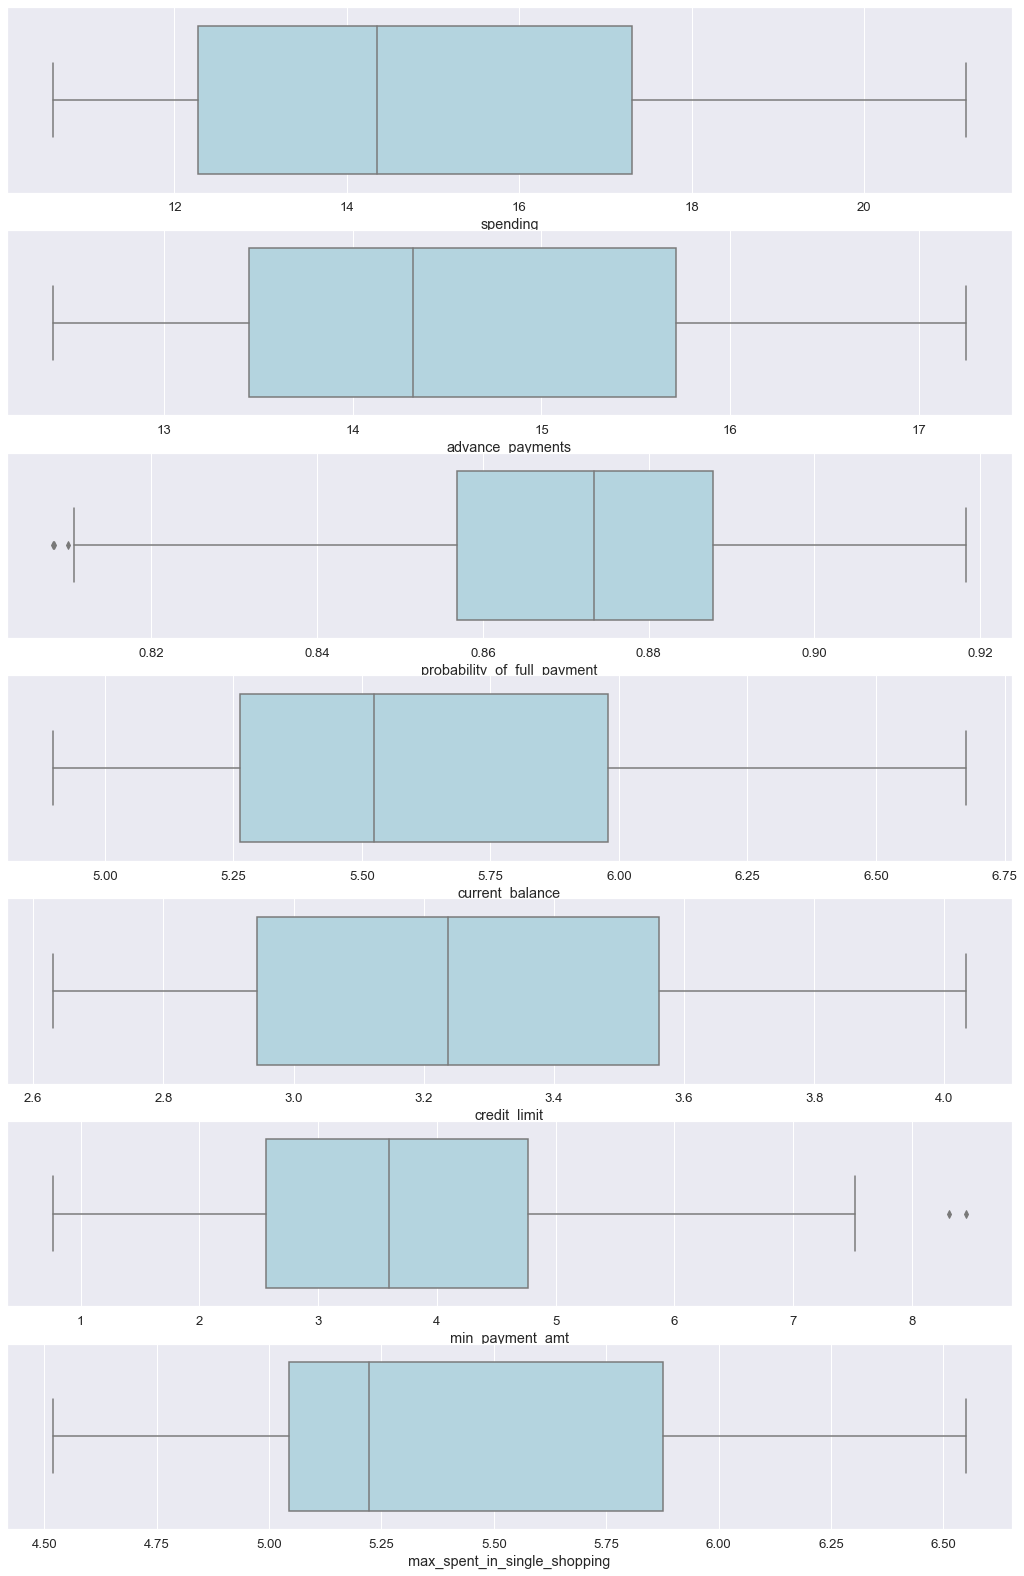

In [1187]:
plt.figure(figsize = (18,28))

plt.subplot(7,1,1)
sns.boxplot(x = bank.spending, color = 'lightblue')

plt.subplot(7,1,2)
sns.boxplot(x = bank.advance_payments, color = 'lightblue')

plt.subplot(7,1,3)
sns.boxplot(x = bank.probability_of_full_payment, color = 'lightblue')

plt.subplot(7,1,4)
sns.boxplot(x = bank.current_balance, color = 'lightblue')

plt.subplot(7,1,5)
sns.boxplot(x = bank.credit_limit, color = 'lightblue')

plt.subplot(7,1,6)
sns.boxplot(x = bank.min_payment_amt, color = 'lightblue')

plt.subplot(7,1,7)
sns.boxplot(x = bank.max_spent_in_single_shopping, color = 'lightblue')

In [1195]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lr_range= Q1-(1.5 * IQR)
    ur_range= Q3+(1.5 * IQR)
    return lr_range, ur_range

In [1196]:
lprob,uprob = remove_outlier(bank['probability_of_full_payment'])
bank['probability_of_full_payment']=np.where(bank['probability_of_full_payment']<lprob,lprob,bank['probability_of_full_payment'])
bank['probability_of_full_payment']=np.where(bank['probability_of_full_payment']>uprob,uprob,bank['probability_of_full_payment'])

lmin,umin = remove_outlier(bank['min_payment_amt'])
bank['min_payment_amt']=np.where(bank['min_payment_amt']<lmin,lmin,bank['min_payment_amt'])
bank['min_payment_amt']=np.where(bank['min_payment_amt']>umin,umin,bank['min_payment_amt'])

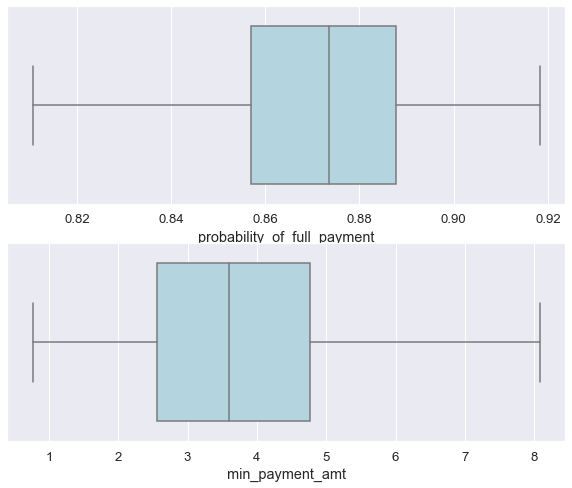

In [1197]:
plt.figure(figsize = (10,8))

plt.subplot(2,1,1)
sns.boxplot(x = bank.probability_of_full_payment, color = 'lightblue')

plt.subplot(2,1,2)
sns.boxplot(x = bank.min_payment_amt, color = 'lightblue')

In [1198]:
corr = bank.corr()
corr

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
spending,1.000000,0.994341,0.608900,0.949985,0.970771,-0.229619,0.863693
advance_payments,0.994341,1.000000,0.529925,0.972422,0.944829,-0.217051,0.890784
probability_of_full_payment,0.608900,0.529925,1.000000,0.368419,0.762218,-0.335071,0.227140
current_balance,0.949985,0.972422,0.368419,1.000000,0.860415,-0.170701,0.932806
credit_limit,0.970771,0.944829,0.762218,0.860415,1.000000,-0.258980,0.749131
min_payment_amt,-0.229619,-0.217051,-0.335071,-0.170701,-0.258980,1.000000,-0.009605
max_spent_in_single_shopping,0.863693,0.890784,0.227140,0.932806,0.749131,-0.009605,1.000000


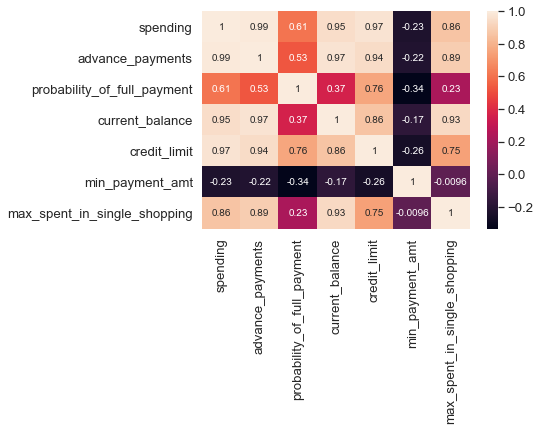

In [1199]:
sns.heatmap(corr, annot = True)

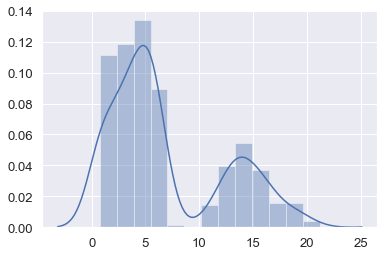

In [1200]:
sns.distplot(bank, hist = True, kde = True)

In [1201]:
bank.skew()

spending                        0.399889
advance_payments                0.386573
probability_of_full_payment    -0.522793
current_balance                 0.525482
credit_limit                    0.134378
min_payment_amt                 0.360001
max_spent_in_single_shopping    0.561897
dtype: float64

1.2  Do you think scaling is necessary for clustering in this case? Justify.

Ans. From the above viz's the data is not normal and few variables are skewed, so there is need of scaling.

In [1202]:
std_scaler = StandardScaler()

In [1203]:
scaled_data = std_scaler.fit_transform(bank)
scaled_data

array([[ 1.75435461,  1.81196782,  0.177628  , ...,  1.33857863,
        -0.29862524,  2.3289982 ],
       [ 0.39358228,  0.25383997,  1.50507052, ...,  0.85823561,
        -0.24229198, -0.53858174],
       [ 1.41330028,  1.42819249,  0.505234  , ...,  1.317348  ,
        -0.22083168,  1.50910692],
       ...,
       [-0.2816364 , -0.30647202,  0.36483143, ..., -0.15287318,
        -1.32804867, -0.83023461],
       [ 0.43836719,  0.33827054,  1.23277462, ...,  0.60081421,
        -0.95718798,  0.07123789],
       [ 0.24889256,  0.45340314, -0.77966228, ..., -0.07325831,
        -0.70905334,  0.96047321]])

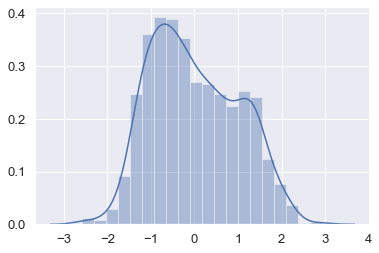

In [1204]:
sns.distplot(scaled_data, hist = True, kde = True)

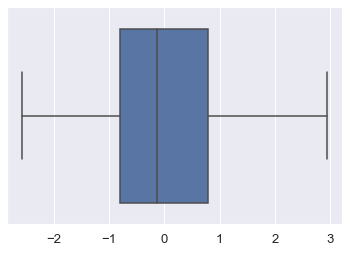

In [1205]:
sns.boxplot(scaled_data)

1.3 Apply hierarchical clustering to scaled data. Identify the number of optimum clusters using Dendrogram and 
briefly describe them.

In [1206]:
wardlink = linkage(scaled_data, method = 'ward')

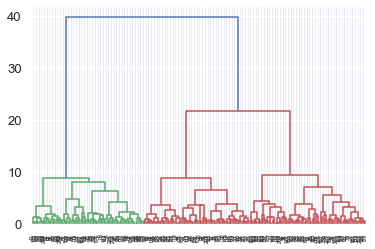

In [1207]:
dendo = dendrogram(wardlink)

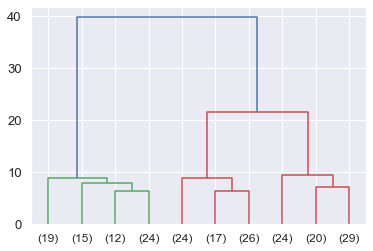

In [1208]:
dendo = dendrogram(wardlink, truncate_mode = 'lastp', p = 10)

In [1209]:
# method1

clusters1 = fcluster(wardlink, 3, criterion = 'maxclust')
clusters1

array([1, 3, 1, 2, 1, 2, 2, 3, 1, 2, 1, 3, 2, 1, 3, 2, 3, 2, 3, 2, 2, 2,
       1, 2, 3, 1, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 1, 1, 3, 1, 1,
       2, 2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 2, 2, 3, 3, 1,
       1, 3, 1, 2, 3, 2, 1, 1, 2, 1, 3, 2, 1, 3, 3, 3, 3, 1, 2, 3, 3, 1,
       1, 2, 3, 1, 3, 2, 2, 1, 1, 1, 2, 1, 2, 1, 3, 1, 3, 1, 1, 2, 2, 1,
       3, 3, 1, 2, 2, 1, 3, 3, 2, 1, 3, 2, 2, 2, 3, 3, 1, 2, 3, 3, 2, 3,
       3, 1, 2, 1, 1, 2, 1, 3, 3, 3, 2, 2, 3, 2, 1, 2, 3, 2, 3, 2, 3, 3,
       3, 3, 3, 2, 3, 1, 1, 2, 1, 1, 1, 2, 1, 3, 3, 3, 3, 2, 3, 1, 1, 1,
       3, 3, 1, 2, 3, 3, 3, 3, 1, 1, 3, 3, 3, 2, 3, 3, 2, 1, 3, 1, 1, 2,
       1, 2, 3, 1, 3, 2, 1, 3, 1, 3, 1, 3], dtype=int32)

In [1210]:
# method2

clusters2 = fcluster(wardlink, 20, criterion = 'distance')
clusters2

array([1, 3, 1, 2, 1, 2, 2, 3, 1, 2, 1, 3, 2, 1, 3, 2, 3, 2, 3, 2, 2, 2,
       1, 2, 3, 1, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 1, 1, 3, 1, 1,
       2, 2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 2, 2, 3, 3, 1,
       1, 3, 1, 2, 3, 2, 1, 1, 2, 1, 3, 2, 1, 3, 3, 3, 3, 1, 2, 3, 3, 1,
       1, 2, 3, 1, 3, 2, 2, 1, 1, 1, 2, 1, 2, 1, 3, 1, 3, 1, 1, 2, 2, 1,
       3, 3, 1, 2, 2, 1, 3, 3, 2, 1, 3, 2, 2, 2, 3, 3, 1, 2, 3, 3, 2, 3,
       3, 1, 2, 1, 1, 2, 1, 3, 3, 3, 2, 2, 3, 2, 1, 2, 3, 2, 3, 2, 3, 3,
       3, 3, 3, 2, 3, 1, 1, 2, 1, 1, 1, 2, 1, 3, 3, 3, 3, 2, 3, 1, 1, 1,
       3, 3, 1, 2, 3, 3, 3, 3, 1, 1, 3, 3, 3, 2, 3, 3, 2, 1, 3, 1, 1, 2,
       1, 2, 3, 1, 3, 2, 1, 3, 1, 3, 1, 3], dtype=int32)

In [1211]:
np.array_equal(clusters1, clusters2)

True

In [1212]:
bank['clusters'] = clusters1
bank2 = bank
bank2.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,clusters
0,19.94,16.92,0.875200,6.675,3.763,3.252,6.550,1
1,15.99,14.89,0.906400,5.363,3.582,3.336,5.144,3
2,18.95,16.42,0.882900,6.248,3.755,3.368,6.148,1
3,10.83,12.96,0.810588,5.278,2.641,5.182,5.185,2
4,17.99,15.86,0.899200,5.890,3.694,2.068,5.837,1


In [1213]:
bank2.clusters.value_counts().sort_index()

1    70
2    67
3    73
Name: clusters, dtype: int64

In [1214]:
aggregatedata = bank.groupby('clusters').mean()
aggregatedata['frequency'] = bank2.clusters.value_counts().sort_index()
aggregatedata

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,frequency
clusters,,,,,,,,
1,18.371429,16.145429,0.884400,6.158171,3.684629,3.639157,6.017371,70
2,11.872388,13.257015,0.848155,5.238940,2.848537,4.940302,5.122209,67
3,14.199041,14.233562,0.879190,5.478233,3.226452,2.612181,5.086178,73


1.4 Apply K-Means clustering on scaled data and determine optimum clusters. Apply elbow curve and silhouette score.

In [1215]:
k_means = KMeans(n_clusters = 3,random_state = 0)
k_means.fit(scaled_data)
k_means.labels_

array([2, 1, 2, 0, 2, 0, 0, 1, 2, 0, 2, 1, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0,
       2, 0, 1, 2, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2,
       0, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 1, 0, 0, 1, 1, 2,
       2, 1, 2, 0, 1, 0, 2, 2, 0, 2, 1, 0, 2, 1, 1, 1, 1, 2, 0, 1, 2, 1,
       2, 0, 1, 2, 1, 0, 0, 2, 2, 2, 0, 2, 1, 2, 1, 2, 1, 2, 2, 0, 0, 2,
       1, 1, 2, 0, 0, 2, 1, 1, 0, 2, 1, 0, 0, 0, 1, 1, 2, 0, 1, 1, 0, 1,
       1, 2, 0, 2, 2, 0, 2, 1, 1, 1, 0, 0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 2, 2, 0, 2, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 2, 2, 2,
       1, 0, 1, 0, 1, 1, 1, 1, 2, 2, 0, 1, 1, 0, 0, 1, 0, 2, 1, 2, 2, 0,
       2, 0, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1])

In [1216]:
 wss = []

In [1217]:
for j in range(1,11):
    KM = KMeans(n_clusters = j)
    KM.fit(scaled_data)
    wss.append(KM.inertia_)

In [1218]:
wss

[1469.9999999999998,
 659.1474009548498,
 430.298481751223,
 370.8685962394206,
 326.1103974877663,
 290.00750305055453,
 263.0918046671117,
 241.01094762466997,
 223.04349916884755,
 205.93047391875788]

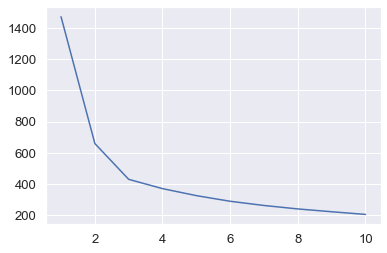

In [1219]:
plt.plot(range(1,11), wss)

In [1220]:
# For 2 clusters

k_means = KMeans(n_clusters = 2, random_state = 0)
k_means.fit(scaled_data)
labels1 = k_means.labels_
labels1

array([1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1])

In [1221]:
silhouette_score(scaled_data,labels1)

0.46560100442748986

In [1222]:
silhouette_samples(scaled_data, labels1).min()

-0.0056773797277176906

In [1223]:
# For 3 clusters

K_means2 = KMeans(n_clusters = 3, random_state = 0)
K_means2.fit(scaled_data)
labels2 = K_means2.labels_
labels2

array([2, 1, 2, 0, 2, 0, 0, 1, 2, 0, 2, 1, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0,
       2, 0, 1, 2, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2,
       0, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 1, 0, 0, 1, 1, 2,
       2, 1, 2, 0, 1, 0, 2, 2, 0, 2, 1, 0, 2, 1, 1, 1, 1, 2, 0, 1, 2, 1,
       2, 0, 1, 2, 1, 0, 0, 2, 2, 2, 0, 2, 1, 2, 1, 2, 1, 2, 2, 0, 0, 2,
       1, 1, 2, 0, 0, 2, 1, 1, 0, 2, 1, 0, 0, 0, 1, 1, 2, 0, 1, 1, 0, 1,
       1, 2, 0, 2, 2, 0, 2, 1, 1, 1, 0, 0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 2, 2, 0, 2, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 2, 2, 2,
       1, 0, 1, 0, 1, 1, 1, 1, 2, 2, 0, 1, 1, 0, 0, 1, 0, 2, 1, 2, 2, 0,
       2, 0, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1])

In [1224]:
silhouette_score(scaled_data,labels2)

0.4008059221522216

In [1225]:
silhouette_samples(scaled_data, labels2).min()

0.002768541128616533

In [1226]:
# For 4 clusters

K_means3 = KMeans(n_clusters = 4, random_state = 0)
K_means3.fit(scaled_data)
labels3 = K_means3.labels_

In [1227]:
silhouette_score(scaled_data,labels3)

0.32783548276481184

In [1228]:
silhouette_samples(scaled_data, labels3).min()

-0.05493173343527373

In [1229]:
# for 5 clusters

K_means4 = KMeans(n_clusters = 5, random_state = 0)
K_means4.fit(scaled_data)
labels4 = K_means4.labels_

In [1230]:
silhouette_score(scaled_data,labels4)

0.2879267671344362

In [1231]:
silhouette_samples(scaled_data, labels4).min()

-0.07352556341814181

In [1232]:
# sil Scores and widths

s_list = [['0.465','0.400','0.327','0.287'], ['-0.005','0.002','-0.054','-0.073']] 

scores = pd.DataFrame(s_list, index = ['sil_score','sil_width'], 
                      columns = ['2_clusters','3_clusters','4_clusters','5_clusters'])
scores

,2_clusters,3_clusters,4_clusters,5_clusters
sil_score,0.465,0.400,0.327,0.287
sil_width,-0.005,0.002,-0.054,-0.073


In [1233]:
# Best no of clusters
sil_width = silhouette_samples(scaled_data, labels2)

In [1234]:
bank2["sil_width"] = sil_width
bank2["Clus_kmeans"] = labels2
bank3 = bank
bank3.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,clusters,sil_width,Clus_kmeans
0,19.94,16.92,0.875200,6.675,3.763,3.252,6.550,1,0.573278,2
1,15.99,14.89,0.906400,5.363,3.582,3.336,5.144,3,0.365564,1
2,18.95,16.42,0.882900,6.248,3.755,3.368,6.148,1,0.637092,2
3,10.83,12.96,0.810588,5.278,2.641,5.182,5.185,2,0.515595,0
4,17.99,15.86,0.899200,5.890,3.694,2.068,5.837,1,0.360972,2


In [1235]:
bank.Clus_kmeans.value_counts().sort_index()

0    72
1    71
2    67
Name: Clus_kmeans, dtype: int64

In [1236]:
cluster_profile = bank
cluster_profile = cluster_profile.groupby('Clus_kmeans').mean()
cluster_profile['freq'] = bank.Clus_kmeans.value_counts().sort_index()
cluster_profile

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,clusters,sil_width,freq
Clus_kmeans,,,,,,,,,,
0,11.856944,13.247778,0.848330,5.231750,2.849542,4.733892,5.101722,2.083333,0.399556,72
1,14.437887,14.337746,0.881597,5.514577,3.259225,2.707341,5.120803,2.873239,0.338593,71
2,18.495373,16.203433,0.884210,6.175687,3.697537,3.632373,6.041701,1.029851,0.468077,67


1.5 Describe cluster profiles for the clusters defined. Recommend different promotional strategies for different clusters.

In [1241]:
c_list = [['0','1','2'], ['72','71','67']] 

Clus_prof = pd.DataFrame(c_list, index = ['Kmeans_clusters','Freq'])
Clus_prof

,0,1,2
Kmeans_clusters,0,1,2
Freq,72,71,67


In [1245]:
bank['clusters'] = labels2

In [1248]:
bank.to_csv('clster_profs.csv')

Find answer in Business report

# Problem 2

Problem 2: CART-RF-ANN

An Insurance firm providing tour insurance is facing higher claim frequency. The management decides to collect data from the past few years. You are assigned the task to make a model which predicts the claim status and provide recommendations to management. Use CART, RF & ANN and compare the models' performances in train and test sets.


Dataset for Problem 2: insurance_part2_data-1.csv

Attribute Information:

1. Target: Claim Status (Claimed)

2. Code of tour firm (Agency_Code)

3. Type of tour insurance firms (Type)

4. Distribution channel of tour insurance agencies (Channel)

5. Name of the tour insurance products (Product)

6. Duration of the tour (Duration)

7. Destination of the tour (Destination)

8. Amount of sales of tour insurance policies (Sales)

9. The commission received for tour insurance firm (Commission)

10. Age of insured (Age)

2.1 Data Ingestion: Read the dataset. Do the descriptive statistics and do null value condition check, write an inference on it.







In [1250]:
ins_firm = pd.read_csv('insurance_part2_data.csv')
ins_firm.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


In [1251]:
ins_firm.drop(columns = 'Agency_Code', inplace = True)

In [1252]:
ins_firm.shape

(3000, 9)

In [1253]:
ins_firm.describe()

,Age,Commision,Duration,Sales
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,38.091000,14.529203,70.001333,60.249913
std,10.463518,25.481455,134.053313,70.733954
min,8.000000,0.000000,-1.000000,0.000000
25%,32.000000,0.000000,11.000000,20.000000
50%,36.000000,4.630000,26.500000,33.000000
75%,42.000000,17.235000,63.000000,69.000000
max,84.000000,210.210000,4580.000000,539.000000


In [1254]:
ins_firm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Type          3000 non-null   object 
 2   Claimed       3000 non-null   object 
 3   Commision     3000 non-null   float64
 4   Channel       3000 non-null   object 
 5   Duration      3000 non-null   int64  
 6   Sales         3000 non-null   float64
 7   Product Name  3000 non-null   object 
 8   Destination   3000 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 211.1+ KB


In [1255]:
ins_firm.isnull().sum()

Age             0
Type            0
Claimed         0
Commision       0
Channel         0
Duration        0
Sales           0
Product Name    0
Destination     0
dtype: int64

In [1256]:
# Unique count of variables

for column in ins_firm[['Age','Type','Claimed','Commision','Channel','Duration','Sales',
                        'Product Name','Destination']]:
    print(column.upper(), ':', ins_firm[column].nunique())
    print(ins_firm[column].value_counts().sort_values())
    print('\n')

AGE : 70
8       1
14      1
83      1
77      1
84      1
     ... 
35     94
30     96
48    108
31    125
36    999
Name: Age, Length: 70, dtype: int64


TYPE : 2
Airlines         1163
Travel Agency    1837
Name: Type, dtype: int64


CLAIMED : 2
Yes     924
No     2076
Name: Claimed, dtype: int64


COMMISION : 324
126.75       1
12.45        1
46.80        1
21.35        1
17.55        1
          ... 
7.70        57
23.76       61
54.00       61
63.21       62
0.00      1366
Name: Commision, Length: 324, dtype: int64


CHANNEL : 2
Offline      46
Online     2954
Name: Channel, dtype: int64


DURATION : 257
4580     1
149      1
141      1
215      1
217      1
        ..
11      81
10      81
6       81
5       82
8       83
Name: Duration, Length: 257, dtype: int64


SALES : 380
271.00      1
62.40       1
491.50      1
159.00      1
100.50      1
         ... 
216.00     59
252.85     60
22.00      79
10.00     163
20.00     225
Name: Sales, Length: 380, dtype: int64


PRODUCT NA

In [1257]:
dups = ins_firm.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
ins_firm[dups]

Number of duplicate rows = 139


,Age,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
63,30,Airlines,Yes,15.0,Online,27,60.0,Bronze Plan,ASIA
329,36,Travel Agency,No,0.0,Online,5,20.0,Customised Plan,ASIA
407,36,Travel Agency,No,0.0,Online,11,19.0,Cancellation Plan,ASIA
411,35,Travel Agency,No,0.0,Online,2,20.0,Customised Plan,ASIA
422,36,Travel Agency,No,0.0,Online,5,20.0,Customised Plan,ASIA
...,...,...,...,...,...,...,...,...,...
2940,36,Travel Agency,No,0.0,Online,8,10.0,Cancellation Plan,ASIA
2947,36,Travel Agency,No,0.0,Online,10,28.0,Customised Plan,ASIA
2952,36,Travel Agency,No,0.0,Online,2,10.0,Cancellation Plan,ASIA
2962,36,Travel Agency,No,0.0,Online,4,20.0,Customised Plan,ASIA


In [1258]:
ins_firm.drop_duplicates(inplace = True)

In [1259]:
dups = ins_firm.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
print(ins_firm.shape)

Number of duplicate rows = 0
(2861, 9)


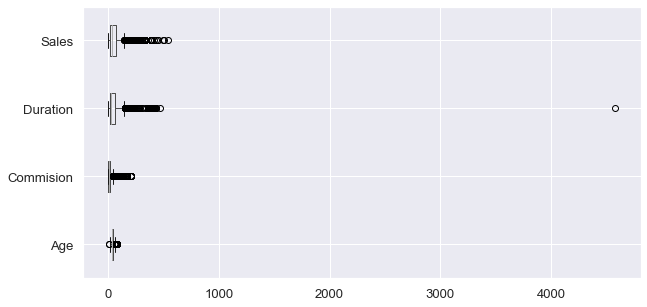

In [1260]:
plt.figure(figsize = (10,5))
ins_firm[['Age','Commision','Duration','Sales']].boxplot(vert = 0)

In [1261]:
ls,us = remove_outlier(ins_firm['Sales'])
ins_firm['Sales']=np.where(ins_firm['Sales']<ls,ls,ins_firm['Sales'])
ins_firm['Sales']=np.where(ins_firm['Sales']>us,us,ins_firm['Sales'])

ld,ud = remove_outlier(ins_firm['Duration'])
ins_firm['Duration']=np.where(ins_firm['Duration']<ld,ld,ins_firm['Duration'])
ins_firm['Duration']=np.where(ins_firm['Duration']>ud,ud,ins_firm['Duration'])

lc,uc = remove_outlier(ins_firm['Commision'])
ins_firm['Commision']=np.where(ins_firm['Commision']<lc,lc,ins_firm['Commision'])
ins_firm['Commision']=np.where(ins_firm['Commision']>uc,uc,ins_firm['Commision'])

la,ua = remove_outlier(ins_firm['Age'])
ins_firm['Age']=np.where(ins_firm['Age']<la,la,ins_firm['Age'])
ins_firm['Age']=np.where(ins_firm['Age']>ua,ua,ins_firm['Age'])

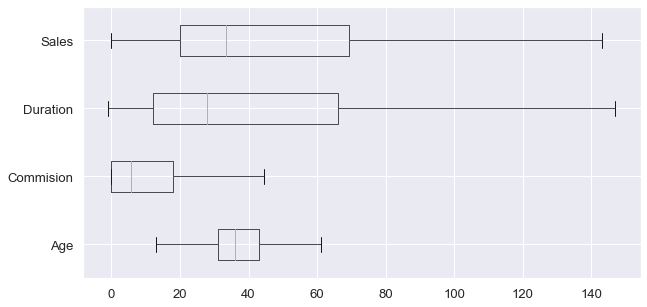

In [1262]:
plt.figure(figsize = (10,5))
ins_firm[['Age','Commision','Duration','Sales']].boxplot(vert = 0)

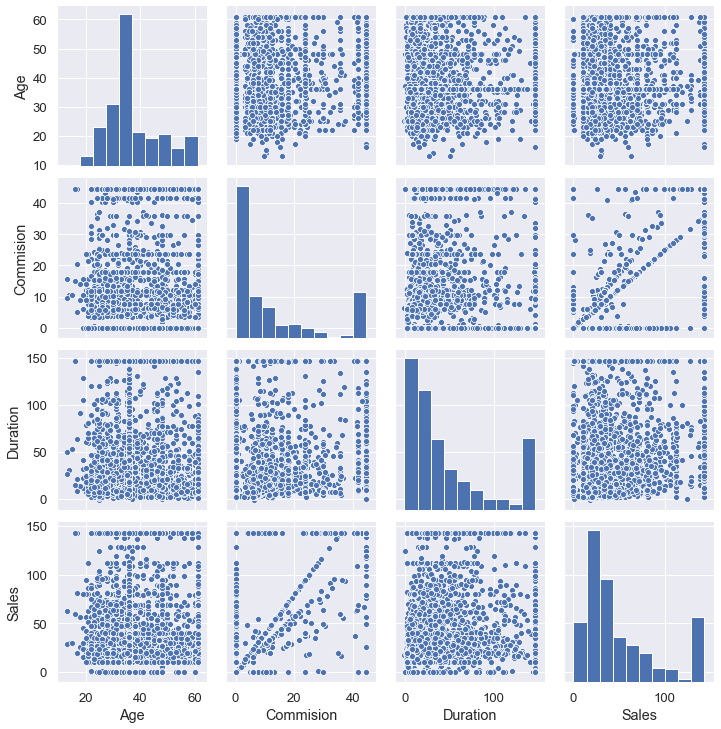

In [1263]:
sns.pairplot(ins_firm)

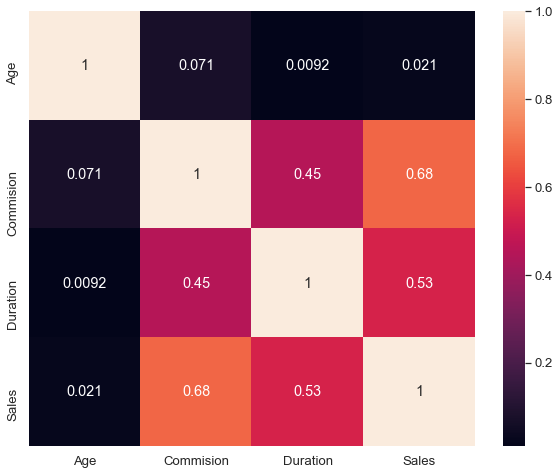

In [1264]:
plt.figure(figsize = (10,8))
sns.set(font_scale = 1.2)
sns.heatmap(ins_firm.corr(), annot = True)

In [1265]:
for variable in ins_firm.columns:
    if ins_firm[variable].dtype == 'object':
        ins_firm[variable] = pd.Categorical(ins_firm[variable]).codes

In [1266]:
ins_firm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2861 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           2861 non-null   float64
 1   Type          2861 non-null   int8   
 2   Claimed       2861 non-null   int8   
 3   Commision     2861 non-null   float64
 4   Channel       2861 non-null   int8   
 5   Duration      2861 non-null   float64
 6   Sales         2861 non-null   float64
 7   Product Name  2861 non-null   int8   
 8   Destination   2861 non-null   int8   
dtypes: float64(4), int8(5)
memory usage: 205.7 KB


In [1268]:
#proportion of 0's and 1's of target variable 'claimed'

ins_firm.Claimed.value_counts(normalize = True)

0    0.680531
1    0.319469
Name: Claimed, dtype: float64

2.2 Data Split: Split the data into test and train, build classification model CART, Random Forest, Artificial Neural Network.

                                                     &
                                                     
2.3 Performance Metrics: Check the performance of Predictions on Train and Test sets using Accuracy, Confusion Matrix, Plot ROC curve and get ROC_AUC score for each model

In [1269]:
X = ins_firm.drop('Claimed', axis = 1)
y = ins_firm.pop('Claimed')

X.head()

,Age,Type,Commision,Channel,Duration,Sales,Product Name,Destination
0,48.0,0,0.70,1,7.0,2.51,2,0
1,36.0,1,0.00,1,34.0,20.00,2,0
2,39.0,1,5.94,1,3.0,9.90,2,1
3,36.0,1,0.00,1,4.0,26.00,1,0
4,33.0,0,6.30,1,53.0,18.00,0,0


In [1270]:
X_train, X_test, train_labels, test_labels = train_test_split(X, y, test_size = .30, random_state = 1)

In [1271]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('train_labels', train_labels.shape)
print('test_labels', test_labels.shape)
print('TotalObs', 2002+859)

X_train (2002, 8)
X_test (859, 8)
train_labels (2002,)
test_labels (859,)
TotalObs 2861


# Classification model for CART.

In [1272]:
param_grid = {
    'criterion': ['gini'],
    'max_depth': [10,20],
    'min_samples_leaf': [20,30],
    'min_samples_split': [30,60],
}

dtcl = DecisionTreeClassifier(random_state = 1)

grid_search = GridSearchCV(estimator = dtcl, param_grid = param_grid, cv = 10)

In [1273]:
grid_search.fit(X_train, train_labels)
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
best_grid

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 60}


DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=60,
                       random_state=1)

In [1274]:
DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=60,
                       random_state=1)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=60,
                       random_state=1)

In [1275]:
train_char_label = ['no', 'yes']
tree_regularized = open('tree_regularized.dot', 'w')
dot_data = tree.export_graphviz(best_grid, out_file = tree_regularized, feature_names = list(X_train), class_names = list(train_char_label))
tree_regularized.close()
dot_data

In [1276]:
#variable importance

print(pd.DataFrame(best_grid.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values('Imp', ascending = False))

                   Imp
Product Name  0.582288
Sales         0.199362
Commision     0.078513
Age           0.069959
Duration      0.067790
Destination   0.002088
Type          0.000000
Channel       0.000000


In [1277]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [1278]:
ytest_predict
ytest_predict_prob = best_grid.predict_proba(X_test)
ytest_predict_prob
pd.DataFrame(ytest_predict_prob).head()

,0,1
0,0.722222,0.277778
1,1.000000,0.000000
2,0.391304,0.608696
3,0.711538,0.288462
4,0.745455,0.254545


Performance metrics of Trained data

In [1279]:
confusion_matrix(train_labels, ytrain_predict)

array([[1209,  150],
       [ 287,  356]], dtype=int64)

In [1280]:
# Train Data Accuracy

cart_train_acc = best_grid.score(X_train, train_labels)
cart_train_acc

0.7817182817182817

In [1281]:
print(classification_report(train_labels, ytrain_predict))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1359
           1       0.70      0.55      0.62       643

    accuracy                           0.78      2002
   macro avg       0.76      0.72      0.73      2002
weighted avg       0.77      0.78      0.77      2002



In [1282]:
cart_metrics = classification_report(train_labels, ytrain_predict, output_dict = True)
df = pd.DataFrame(cart_metrics).transpose()
cart_train_f1 = round(df.loc["1"][2],2)
cart_train_recall = round(df.loc["1"][1],2)
cart_train_precision = round(df.loc["1"][0],2)
print('cart_train_precision', cart_train_precision)
print('cart_train_recall', cart_train_recall)
print('cart_train_f1', cart_train_f1)

cart_train_precision 0.7
cart_train_recall 0.55
cart_train_f1 0.62


AUC: 0.847


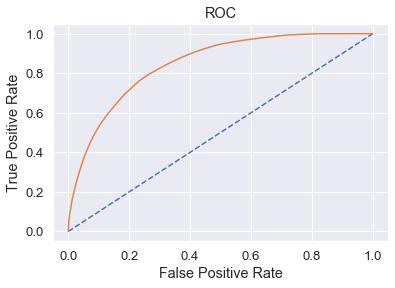

In [1283]:
# AUC score & ROC curve for Trained data

probs = best_grid.predict_proba(X_train)
probs = probs[:, 1]
cart_train_auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % cart_train_auc)
cart_train_fpr, cart_train_tpr, cart_train_thresholds = roc_curve(train_labels, probs)
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.plot(cart_train_fpr, cart_train_tpr)

Performance metrics of Test data

In [1284]:
confusion_matrix(test_labels, ytest_predict)

array([[514,  74],
       [135, 136]], dtype=int64)

In [1285]:
# Test Data Accuracy

cart_test_acc = best_grid.score(X_test, test_labels)
cart_test_acc

0.7566938300349243

In [1286]:
print(classification_report(test_labels, ytest_predict))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       588
           1       0.65      0.50      0.57       271

    accuracy                           0.76       859
   macro avg       0.72      0.69      0.70       859
weighted avg       0.75      0.76      0.75       859



In [1287]:
cart_metrics = classification_report(test_labels, ytest_predict, output_dict = True)
df = pd.DataFrame(cart_metrics).transpose()
cart_test_precision = round(df.loc["1"][0],2)
cart_test_recall = round(df.loc["1"][1],2)
cart_test_f1 = round(df.loc["1"][2],2)
print('cart_test_precision', cart_test_precision)
print('cart_test_recall', cart_test_recall)
print('cart_test_f1', cart_test_f1)

cart_test_precision 0.65
cart_test_recall 0.5
cart_test_f1 0.57


AUC: 0.783


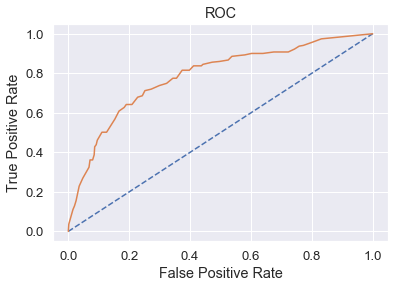

In [1288]:
# AUC score & ROC curve for Test data

probs = best_grid.predict_proba(X_test)
probs = probs[:, 1]
cart_test_auc = roc_auc_score(test_labels, probs)
print('AUC: %.3f' % cart_test_auc)
cart_test_fpr, cart_test_tpr, cart_test_thresholds = roc_curve(test_labels, probs)
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.plot(cart_test_fpr, cart_test_tpr)

# Classification model for Random Forest

In [1289]:
param_grid = {
    'max_depth': [10,20],
    'max_features': [6,7],
    'min_samples_leaf': [10,20],
    'min_samples_split': [30,60],
    'n_estimators': [200,300]
}

rfcl = RandomForestClassifier(random_state = 1)

grid_search = GridSearchCV(estimator = rfcl, param_grid = param_grid, cv = 5)

In [1290]:
grid_search.fit(X_train, train_labels)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [10, 20], 'max_features': [6, 7],
                         'min_samples_leaf': [10, 20],
                         'min_samples_split': [30, 60],
                         'n_estimators': [200, 300]})

In [1291]:
grid_search.best_params_

{'max_depth': 10,
 'max_features': 6,
 'min_samples_leaf': 10,
 'min_samples_split': 30,
 'n_estimators': 300}

In [1292]:
best_grid = grid_search.best_estimator_

In [1293]:
best_grid = grid_search.best_estimator_
best_grid

RandomForestClassifier(max_depth=10, max_features=6, min_samples_leaf=10,
                       min_samples_split=30, n_estimators=300, random_state=1)

In [1294]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

Performance metrics of Trained data

In [1295]:
confusion_matrix(train_labels, ytrain_predict)

array([[1221,  138],
       [ 251,  392]], dtype=int64)

In [1296]:
rf_train_acc = best_grid.score(X_train, train_labels)
rf_train_acc

0.8056943056943057

In [1297]:
print(classification_report(train_labels, ytrain_predict))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1359
           1       0.74      0.61      0.67       643

    accuracy                           0.81      2002
   macro avg       0.78      0.75      0.77      2002
weighted avg       0.80      0.81      0.80      2002



In [1298]:
rf_metrics = classification_report(train_labels, ytrain_predict, output_dict = True)
df = pd.DataFrame(rf_metrics).transpose()
rf_train_precision = round(df.loc["1"][0],2)
rf_train_recall = round(df.loc["1"][1],2)
rf_train_f1 = round(df.loc["1"][2],2)
print('rf_train_precision', rf_train_precision)
print('rf_train_recall', rf_train_recall)
print('rf_train_f1', rf_train_f1)

rf_train_precision 0.74
rf_train_recall 0.61
rf_train_f1 0.67


Area under curve is 0.8748536626395998


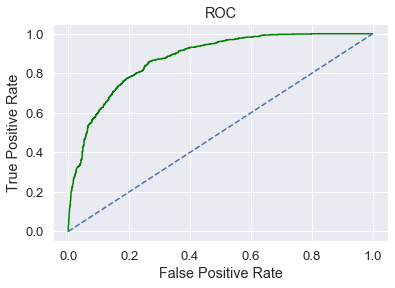

In [1299]:
rf_train_fpr, rf_train_tpr,_ = roc_curve(train_labels, best_grid.predict_proba(X_train)[:,1])
plt.plot(rf_train_fpr, rf_train_tpr, color = 'green')
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
rf_train_auc = roc_auc_score(train_labels,best_grid.predict_proba(X_train)[:,1])
print('Area under curve is', rf_train_auc)

Performance metrics of Test data

In [1300]:
confusion_matrix(test_labels,ytest_predict)

array([[521,  67],
       [125, 146]], dtype=int64)

In [1301]:
rf_test_acc=best_grid.score(X_test,test_labels)
rf_test_acc

0.7764842840512224

In [1302]:
print(classification_report(test_labels,ytest_predict))

              precision    recall  f1-score   support

           0       0.81      0.89      0.84       588
           1       0.69      0.54      0.60       271

    accuracy                           0.78       859
   macro avg       0.75      0.71      0.72       859
weighted avg       0.77      0.78      0.77       859



In [1303]:
rf_metrics=classification_report(test_labels, ytest_predict,output_dict=True)
df=pd.DataFrame(rf_metrics).transpose()
rf_test_precision=round(df.loc["1"][0],2)
rf_test_recall=round(df.loc["1"][1],2)
rf_test_f1=round(df.loc["1"][2],2)
print ('rf_test_precision ',rf_test_precision)
print ('rf_test_recall ',rf_test_recall)
print ('rf_test_f1 ',rf_test_f1)

rf_test_precision  0.69
rf_test_recall  0.54
rf_test_f1  0.6


Area under Curve is 0.8104933855461003


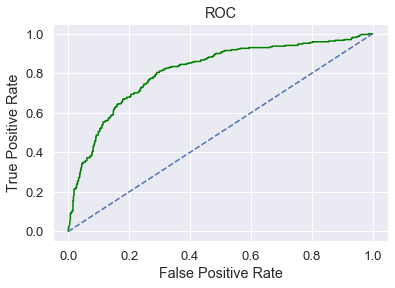

In [1304]:
rf_test_fpr, rf_test_tpr,_=roc_curve(test_labels,best_grid.predict_proba(X_test)[:,1])
plt.plot(rf_test_fpr,rf_test_tpr,color='green')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
rf_test_auc=roc_auc_score(test_labels,best_grid.predict_proba(X_test)[:,1])
print('Area under Curve is', rf_test_auc)

In [1305]:
print (pd.DataFrame(best_grid.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values('Imp',ascending=False))

                   Imp
Product Name  0.373683
Sales         0.209674
Commision     0.153685
Duration      0.116614
Age           0.098582
Type          0.033292
Destination   0.013508
Channel       0.000962


# Classification model for Neural Networks

In [1306]:
param_grid = {
    
    'hidden_layer_sizes': [100], # 50, 200
    'max_iter': [2500], #5000,2500
    'solver': ['adam'], #sgd
    'tol': [0.01], 
}

nncl = MLPClassifier(random_state=1)

grid_search = GridSearchCV(estimator = nncl, param_grid = param_grid, cv = 10)

In [1307]:
grid_search.fit(X_train, train_labels)
grid_search.best_params_

{'hidden_layer_sizes': 100, 'max_iter': 2500, 'solver': 'adam', 'tol': 0.01}

In [1308]:
best_grid = grid_search.best_estimator_
best_grid

MLPClassifier(hidden_layer_sizes=100, max_iter=2500, random_state=1, tol=0.01)

In [1309]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

Performance metrics of Trained data

In [1310]:
confusion_matrix(train_labels,ytrain_predict)

array([[1204,  155],
       [ 347,  296]], dtype=int64)

In [1311]:
nn_train_acc=best_grid.score(X_train,train_labels) 
nn_train_acc

0.7492507492507493

In [1312]:
print(classification_report(train_labels,ytrain_predict))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1359
           1       0.66      0.46      0.54       643

    accuracy                           0.75      2002
   macro avg       0.72      0.67      0.68      2002
weighted avg       0.74      0.75      0.74      2002



In [1313]:
nn_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df=pd.DataFrame(nn_metrics).transpose()
nn_train_precision=round(df.loc["1"][0],2)
nn_train_recall=round(df.loc["1"][1],2)
nn_train_f1=round(df.loc["1"][2],2)
print ('nn_train_precision ',nn_train_precision)
print ('nn_train_recall ',nn_train_recall)
print ('nn_train_f1 ',nn_train_f1)

nn_train_precision  0.66
nn_train_recall  0.46
nn_train_f1  0.54


Area under Curve is 0.7441942833732149


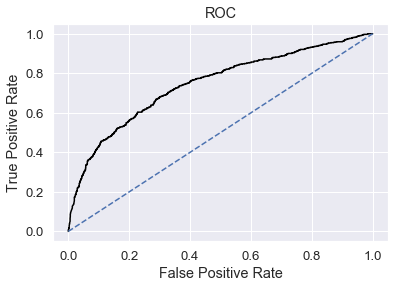

In [1314]:
nn_train_fpr, nn_train_tpr,_=roc_curve(train_labels,best_grid.predict_proba(X_train)[:,1])
plt.plot(nn_train_fpr,nn_train_tpr,color='black')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
nn_train_auc=roc_auc_score(train_labels,best_grid.predict_proba(X_train)[:,1])
print('Area under Curve is', nn_train_auc)

Performance metrics of Test data

In [1315]:
confusion_matrix(test_labels,ytest_predict)

array([[516,  72],
       [150, 121]], dtype=int64)

In [1316]:
nn_test_acc=best_grid.score(X_test,test_labels)
nn_test_acc

0.7415599534342259

In [1317]:
print(classification_report(test_labels,ytest_predict))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       588
           1       0.63      0.45      0.52       271

    accuracy                           0.74       859
   macro avg       0.70      0.66      0.67       859
weighted avg       0.73      0.74      0.73       859



In [1318]:
nn_metrics=classification_report(test_labels, ytest_predict,output_dict=True)
df=pd.DataFrame(nn_metrics).transpose()
nn_test_precision=round(df.loc["1"][0],2)
nn_test_recall=round(df.loc["1"][1],2)
nn_test_f1=round(df.loc["1"][2],2)
print ('nn_test_precision ',nn_test_precision)
print ('nn_test_recall ',nn_test_recall)
print ('nn_test_f1 ',nn_test_f1)

nn_test_precision  0.63
nn_test_recall  0.45
nn_test_f1  0.52


Area under Curve is 0.7445967316816026


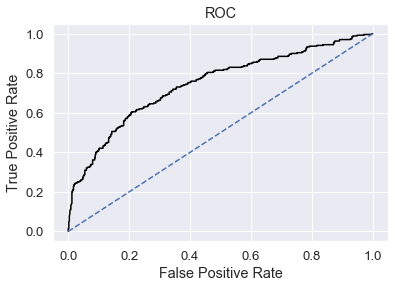

In [1319]:
nn_test_fpr, nn_test_tpr,_=roc_curve(test_labels,best_grid.predict_proba(X_test)[:,1])
plt.plot(nn_test_fpr,nn_test_tpr,color='black')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
nn_test_auc=roc_auc_score(test_labels,best_grid.predict_proba(X_test)[:,1])
print('Area under Curve is', nn_test_auc)

In [1320]:
best_grid.score

<bound method ClassifierMixin.score of MLPClassifier(hidden_layer_sizes=100, max_iter=2500, random_state=1, tol=0.01)>

2.4 Final Model: Compare all the model and write an inference which model is best/optimized.

In [1321]:
index=['Accuracy', 'AUC', 'Recall','Precision','F1 Score']
data = pd.DataFrame({'CART Train':[cart_train_acc,cart_train_auc,cart_train_recall,cart_train_precision,cart_train_f1],
        'CART Test':[cart_test_acc,cart_test_auc,cart_test_recall,cart_test_precision,cart_test_f1],
       'Random Forest Train':[rf_train_acc,rf_train_auc,rf_train_recall,rf_train_precision,rf_train_f1],
        'Random Forest Test':[rf_test_acc,rf_test_auc,rf_test_recall,rf_test_precision,rf_test_f1],
       'Neural Network Train':[nn_train_acc,nn_train_auc,nn_train_recall,nn_train_precision,nn_train_f1],
        'Neural Network Test':[nn_test_acc,nn_test_auc,nn_test_recall,nn_test_precision,nn_test_f1]},index=index)
round(data,2)

,CART Train,CART Test,Random Forest Train,Random Forest Test,Neural Network Train,Neural Network Test
Accuracy,0.78,0.76,0.81,0.78,0.75,0.74
AUC,0.85,0.78,0.87,0.81,0.74,0.74
Recall,0.55,0.50,0.61,0.54,0.46,0.45
Precision,0.70,0.65,0.74,0.69,0.66,0.63
F1 Score,0.62,0.57,0.67,0.60,0.54,0.52


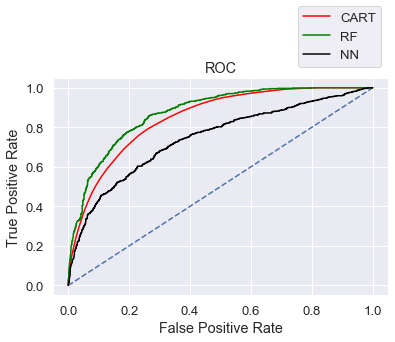

In [1322]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(cart_train_fpr, cart_train_tpr,color='red',label="CART")
plt.plot(rf_train_fpr,rf_train_tpr,color='green',label="RF")
plt.plot(nn_train_fpr,nn_train_tpr,color='black',label="NN")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right')

2.5 Inference: Basis on these predictions, what are the business insights and recommendations

Find answer in Business report

                                                       THE END